In [ ]:
%conda install scikit-learn 



In [ ]:
%conda update -n base -c defaults conda

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [2]:
class dataset(Dataset):

    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y= torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


    def __len__(self):
        return self.length


In [3]:
drugs = pd.read_excel("drug_dataset.xlsx")

In [5]:
drugs.columns

Index(['Unnamed: 0', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity',
       'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS',
       'Alcohol', 'Amphet', 'Unnamed: 15', 'Amyl', 'Benzos', 'Caff',
       'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',
       'LSD', 'Meth', 'Shrooms', 'Nicotine', 'Semer', 'VSA'],
      dtype='object')

In [6]:
types = drugs.columns[13:]

types

Index(['Alcohol', 'Amphet', 'Unnamed: 15', 'Amyl', 'Benzos', 'Caff',
       'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',
       'LSD', 'Meth', 'Shrooms', 'Nicotine', 'Semer', 'VSA'],
      dtype='object')

In [32]:
def create_sub(df, drug):
    cols = ["Age", "Gender","Nscore", "Oscore", "Impulsive", drug]
    subset = df[cols]
    drug_use = subset[drug]

    non_user = ["CL0", "01"]
    user = ["CL" + str(i) for i in range(2, 7)]
    class_ = [0, 1]

    consum_conditions = [(drug_use.isin(non_user)), (drug_use.isin(user))]

    subset[drug] = np.select(consum_conditions, class_)

    return subset



In [39]:
# splitting data into training and testing set
def split_data(df, test_size=0.2):

    X = df.iloc[:,:-1]
    y = df.iloc[:, -1:]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

    data = [x_train, y_train, x_test, y_test]
    data = list(map(lambda df: df.to_numpy(), data))

    x_train, y_train, x_test, y_test = data

    trainset = dataset(x_train, y_train)
    testset = dataset(x_test, y_test)


    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    testloader = DataLoader(testset, batch_size=32, shuffle=False)

    

    return trainloader, testloader


drug_sub = create_sub(drugs, "Heroin")

X = drug_sub.iloc[:,:-1].to_numpy()

y = drug_sub.iloc[:, -1:].to_numpy()


trainloader, testloader = split_data(drug_sub)




/var/folders/5w/zg23p5bd3bnc86d75_pkn99m0000gn/T/ipykernel_74840/3821417972.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[drug] = np.select(consum_conditions, class_)


In [34]:
class Net(nn.Module):

    def __init__(self, input_shape) -> None:
        super(Net, self).__init__()

        self.fc1 = nn.Linear(input_shape, 3)
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.fc2 = nn.Linear(3, 3)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.fc3 = nn.Linear(3, 1)
        nn.init.xavier_uniform_(self.fc3.weight)


        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()        

    
    def forward(self, x):

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))


        return x



        

learning_rate = 0.01
epochs = 750

model = Net(input_shape=X.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

criterion = nn.BCELoss() # Binary cross entropy loss - standard loss function for binary classification




    

In [40]:
losses = []
accur = []


for i in range(epochs):
    for j, (x_train, y_train) in enumerate(trainloader):
        

        output = model(x_train)

        loss = criterion(output, y_train.reshape(-1, 1))

        predicted = model(torch.tensor(X, dtype=torch.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == y).mean()

        #back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



    if i % 50 == 0:
        correct = 0
        total = 0

        losses.append(loss.item())
        accur.append(acc)

        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))



epoch 0	loss : 0.5803191065788269	 accuracy : 0.775971124823224
epoch 50	loss : 0.10342476516962051	 accuracy : 0.8143236074270557
epoch 100	loss : 0.2587529122829437	 accuracy : 0.8143236074270557
epoch 150	loss : 0.13608418405056	 accuracy : 0.8143236074270557
epoch 200	loss : 0.19173260033130646	 accuracy : 0.8143236074270557
epoch 250	loss : 0.5715690851211548	 accuracy : 0.8143236074270557
epoch 300	loss : 0.5799170136451721	 accuracy : 0.8143236074270557
epoch 350	loss : 0.2210564911365509	 accuracy : 0.8143236074270557
epoch 400	loss : 0.4526647925376892	 accuracy : 0.8143236074270557
epoch 450	loss : 0.780820369720459	 accuracy : 0.8143236074270557
epoch 500	loss : 0.2113761603832245	 accuracy : 0.8143236074270557
epoch 550	loss : 0.3804364502429962	 accuracy : 0.8143236074270557
epoch 600	loss : 0.20747166872024536	 accuracy : 0.8143236074270557
epoch 650	loss : 0.15111172199249268	 accuracy : 0.8143236074270557
epoch 700	loss : 0.17216342687606812	 accuracy : 0.81432360742705

In [36]:
#testing 

test_loss = 0
correct, total = 0,0

for data, label in testloader:

    output = model(data)
    for o,l in zip(torch.argmax(output, axis=1), label):
        if o == l:
            correct += 1
        
        total += 1


    loss = criterion(output, label)
    test_loss += loss.item() * data.size(0)

    print(f"Testing loss: {test_loss/len(testloader)}")
    print(f"Correct Predictions: {correct}/ {total}")




Testing loss: 1.1393253008524578
Correct Predictions: 25/ 32
Testing loss: 1.9660023053487141
Correct Predictions: 51/ 64
Testing loss: 2.8137614727020264
Correct Predictions: 76/ 96
Testing loss: 3.9760704040527344
Correct Predictions: 100/ 128
Testing loss: 5.2561421394348145
Correct Predictions: 127/ 160
Testing loss: 6.348636786142985
Correct Predictions: 153/ 192
Testing loss: 7.544979651769002
Correct Predictions: 179/ 224
Testing loss: 8.963742653528849
Correct Predictions: 203/ 256
Testing loss: 10.241230646769205
Correct Predictions: 227/ 288
Testing loss: 11.410006682078043
Correct Predictions: 254/ 320
Testing loss: 12.615532716115316
Correct Predictions: 279/ 352
Testing loss: 13.39677948753039
Correct Predictions: 298/ 377


Text(0, 0.5, 'loss')

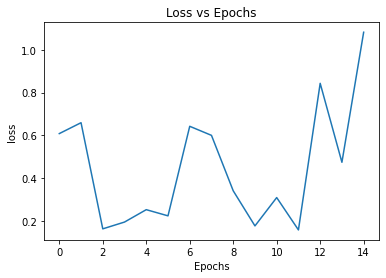

In [37]:
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'Accuracy')

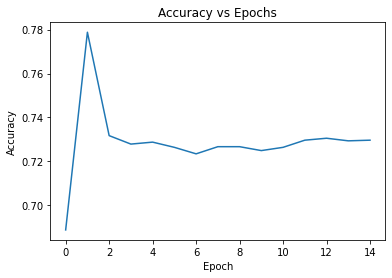

In [38]:
#printing the accuracy
plt.plot(accur)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')